In [1]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
# modified from test.ipynb and main.py

import time
from utils import plot_3d_boundary, plot_3d_observed_rewards
from pylab import *
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import GPy

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.INFO)

from emukit.model_wrappers import GPyModelWrapper
from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy

from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.loop import UserFunctionWrapper

from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.initial_designs import RandomDesign

from GPy.models import GPRegression

from skopt.benchmarks import branin as _branin
from emukit.test_functions import branin_function

from scse.api.simulation import run_simulation

from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt

# Decision loops 
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.quadrature.loop import VanillaBayesianQuadratureLoop

# Acquisition functions 
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.experimental_design.acquisitions import ModelVariance
# from emukit.quadrature.acquisitions import IntegralVarianceReduction
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction

# Acquistion optimizers
from emukit.core.optimization import GradientAcquisitionOptimizer

# Stopping conditions
from emukit.core.loop import FixedIterationsStoppingCondition
from emukit.core.loop import ConvergenceStoppingCondition

from emukit.bayesian_optimization.acquisitions.log_acquisition import LogAcquisition

# Constraints
from emukit.core.constraints import LinearInequalityConstraint

In [3]:
# Libraries for multiprocessing
from multiprocess.pool import Pool
from tqdm.auto import tqdm

In [4]:
from loop import *

In [5]:
print(GPy.__version__)

1.10.0


## miniSCOT Functions

In [6]:
def invoke_miniscot(x):
    """
    Handling single API call to miniSCOT simulation given some inputs

    x contains parameter configs x = [x0 x1 ...]
    - The order of parameters in x should follow the order specified in the parameter_space declaration
    - E.g. here we specify num_batteries = x[0]
    """

    kwargs = {
        'time_horizon': 336*1,
        'num_batteries': int(x[0])
    }

    if len(x) == 2:
        kwargs.update({
            #'max_battery_capacity': int(x[1])
            'battery_penalty': int(x[1])
        })

    if len(x) == 3:
        kwargs.update({
            'max_battery_capacity': int(x[1]),
             #'time_horizon': int(x[2])
            'battery_penalty': int(x[2])
        })
    if len(x) == 4:
        kwargs.update({
            'max_battery_capacity': int(x[1]),
            'time_horizon': int(x[2]),
            'battery_penalty': int(x[3])
        })

    cum_reward = run_simulation(**kwargs)
    
    return cum_reward[-1]

In [7]:
def f(X):
    """
    Handling multiple API calls to miniSCOT simulation given some inputs

    X is a matrix of parameters
    - Each row is a set of parameters
    - The order of parameters in the row should follow the order specified in the parameter_space declaration
    """
    Y = []
    for x in X:
        cum_reward = invoke_miniscot(x)

        # Note that we negate the reward; want to find min
        Y.append(-cum_reward[-1])

    Y = np.reshape(np.array(Y), (-1, 1))
    return Y

In [8]:
def f_multiprocess(X):
    """
    Handling multiple API calls to miniSCOT simulation given some inputs using multiprocessing.

    X is a matrix of parameters
    - Each row is a set of parameters
    - The order of parameters in the row should follow the order specified in the parameter_space declaration
    """
    
    # Set to None to use all available CPU
    max_pool = None
    with Pool(max_pool) as p:
        Y = list(
            tqdm(
                p.imap(invoke_miniscot, X),
                total=X.shape[0]
            )
        )

    # Note that we negate the reward; want to find min
    Y = -np.reshape(np.array(Y), (-1, 1))
    return Y

## Plotting Functions

In [9]:
def plot_reward(X, Y, labels):
    """
    Plots reward against a maximum of two dimensions.
    """

    plt.style.use('seaborn')
    fig = plt.figure(figsize=(12, 12))

    order = np.argsort(X[:,0])
    
    if X.shape[1] == 1:
        ax = plt.axes()
        ax.plot(X[order,0], Y[order])
        ax.set_xlabel(labels[0])
        ax.set_ylabel("Cumulative reward")
    elif X.shape[1] == 2:
        ax = plt.axes(projection='3d')
        im = ax.plot_trisurf(X[order,0].flatten(), X[order,1].flatten(), Y[order].flatten(), cmap=cm.get_cmap('autumn'))
        fig.colorbar(im)
        ax.view_init(90, 90)
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.set_zlabel("Cumulative reward")  # (£/MWh)
    else:
        raise ValueError('X has too many dimensions to plot - max 2 allowed')

    return fig, ax

## Specify Parameter Space

In [10]:
from scse.default_run_parameters.national_grid_default_run_parameters import DEFAULT_RUN_PARAMETERS

In [11]:
max_num_batteries = 1000
min_battery_capacity = 90
max_battery_capacity = 110

# units in £/
min_battery_penalty = DEFAULT_RUN_PARAMETERS.battery_penalty - 100000
max_battery_penalty = DEFAULT_RUN_PARAMETERS.battery_penalty + 100000

num_data_points = 10

timesteps_per_week = 336
num_weeks = 52
time_horizon_value = timesteps_per_week*1

min_time_horizon_value = timesteps_per_week * 1
max_time_horizon_value = timesteps_per_week * 2

num_batteries = DiscreteParameter('num_batteries', range(0, max_num_batteries+1))
max_battery_capacities = DiscreteParameter('max_battery_capacity', range(min_battery_capacity, max_battery_capacity+1))
battery_penalty = DiscreteParameter(
    'battery_penalty', range(min_battery_penalty, max_battery_penalty+1))
time_horizon = DiscreteParameter('time_horizon', range(min_time_horizon_value, max_time_horizon_value+1))

#parameters = [num_batteries, max_battery_capacities, time_horizon, battery_penalty]
parameters = [num_batteries, battery_penalty]
parameter_space = ParameterSpace(parameters)

In [12]:
# Check the parameters of the intial values (X)

design = RandomDesign(parameter_space)
X = design.get_samples(num_data_points)
X

array([[    124, -142626],
       [    631, -150197],
       [    524, -265344],
       [    717, -210533],
       [    351, -152465],
       [    370, -282063],
       [    572, -171640],
       [    849, -165449],
       [    113, -243915],
       [    372, -170601]])

In [13]:
design = RandomDesign(parameter_space)

# Get initial data points
X = design.get_samples(num_data_points)
start = time.time()
Y = f_multiprocess(X)
end = time.time()
print("Getting {} initial simulation points took {} seconds".format(
    num_data_points, round(end - start, 0)))

  0%|          | 0/10 [00:00<?, ?it/s]

Getting 10 initial simulation points took 51.0 seconds


(<Figure size 864x864 with 2 Axes>,
 <Axes3DSubplot:xlabel='num_batteries', ylabel='battery_penalty'>)

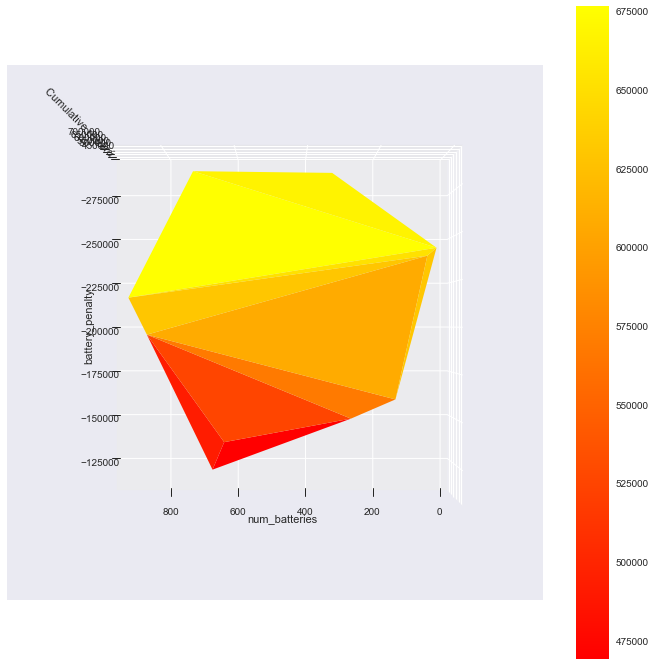

In [14]:
plot_reward(X, Y, parameter_space.parameter_names)


In [ ]:
# Kernel Specification; specify active dimensions
kr = GPy.kern.RBF(input_dim=X.shape[1]-1, active_dims=[0], ARD=True)  # exclude time dim
kb = GPy.kern.Bias(input_dim=X.shape[1]-1, active_dims=[0])
kernel = kr+kb

# Some prior distributions for model parameters
v_prior = GPy.priors.Gamma.from_EV(1000, 100.)
l_prior = GPy.priors.Gamma.from_EV(100, 1000.)

# Some prior distributions for model parameters
gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
gpy_model.kern.rbf.variance.set_prior(v_prior)
gpy_model.kern.rbf.lengthscale.set_prior(l_prior)
gpy_model.Gaussian_noise.variance.constrain_fixed()

# gpy_model.optimize()
gpy_model.optimize_restarts(
    num_restarts=10, robust=False, verbose=False, messages=False)

# Logging GP fit
_ = gpy_model.plot(visible_dims=[0,1])
display(gpy_model)
print(gpy_model.kern.rbf.lengthscale)

model_emukit = GPyModelWrapper(gpy_model)

run_bo = True
if run_bo:
    # ======== Run BO to acquire points but also fit GP =========

    # Choose acquisition function
    ei_acq = ExpectedImprovement(model_emukit)
    acq_func = ei_acq

    # Load core elements for Bayesian optimization
    optimizer = GradientAcquisitionOptimizer(space=parameter_space)

    # Create the Bayesian optimization object
    batch_size = 3
    bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                            space=parameter_space,
                                            acquisition=acq_func,
                                            batch_size=batch_size)

    # Run the loop and extract the optimum;  we either complete 10 steps or converge
    max_iters = 5
    epsilon = 0.01
    stopping_condition = (FixedIterationsStoppingCondition(
        i_max=max_iters) | ConvergenceStoppingCondition(eps=epsilon))

    start = time.time()
    bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
    end = time.time()
    print("Successfully ran loop")

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


GP_regression.,value,constraints,priors
sum.rbf.variance,62451.081034388895,+ve,"Ga(1e+04, 10)"
sum.rbf.lengthscale,15.917709759771107,+ve,"Ga(10, 0.1)"
sum.bias.variance,985682069.9021629,+ve,
Gaussian_noise.variance,1e-10,+ve fixed,


INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model


  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |    priors   
  [0]    |                        15.91770976  |      +ve      |  Ga(10, 0.1)


INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:emukit.core.loop.outer_loop:Iteration 1
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:emukit.core.loop.outer_loop:Iteration 2
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y

new_order = np.argsort(new_X[:,0])
new_X = new_X[new_order,:]
new_Y = new_Y[new_order]
plot_reward(new_X, new_Y, parameter_space.parameter_names)

In [ ]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')

im = ax.plot_trisurf(new_X[:, 0].flatten(), new_X[:, 1].flatten(
), new_Y.flatten(), cmap=cm.get_cmap('autumn'), alpha=0.75)
fig.colorbar(im)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
           new_Y.flatten(), marker="x", color="r", label="All observations")

ax.legend(loc=2, prop={'size': 14})
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_ylabel(r"$f(x)$")
ax.grid(True)
plt.show()

In [ ]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')

im = ax.plot_trisurf(new_X[:, 0].flatten(), new_X[:, 1].flatten(
), new_Y.flatten(), cmap=cm.get_cmap('autumn'), alpha=0.75)
fig.colorbar(im)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
           new_Y.flatten(), marker="x", color="r", label="All observations")

ax.legend(loc=2, prop={'size': 14})
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_ylabel(r"$f(x)$")
ax.grid(True)
ax.view_init(90, 90)
plt.show()

In [19]:
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity, ModelFreeMonteCarloSensitivity

# Use emulator model
sens_sim = ModelFreeMonteCarloSensitivity(f_multiprocess, parameter_space)
sens_emu = MonteCarloSensitivity(model_emukit, parameter_space)

Since running Monte Carlo on the simulator is prohibitively expensive, we evaluate the MC effects on the emulator. 

(I just might run the MC on simulator overnight to compare the accuracy of results)

In [20]:
num_mc = 100000
main_effects, total_effects, _ = sens_emu.compute_effects(
    num_monte_carlo_points=num_mc)

main_effects

{'num_batteries': array([1.00002631]), 'battery_penalty': array([-0.00551398])}

In [21]:
total_effects

{'num_batteries': array([1.00551398]), 'battery_penalty': array([0.00668637])}

In [ ]:
# playground code to generate 3D grid
m_X, m_Y, m_Z = np.mgrid[1:max_num_batteries+1:1, min_battery_capacity:
                         max_battery_capacity+1:1, min_battery_penalty:max_battery_penalty+1:1]

positions = np.vstack([m_X.ravel(), m_Y.ravel(), m_Z.ravel()]).T
positions_with_time = np.append(positions, np.reshape(
    np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)

mu_plot, var_plot = model_emukit.predict(positions_with_time)

Plotting some GP  fit

In [ ]:
# # Get acquired data
# new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
# new_order = np.argsort(new_X[:, 0])
# new_X = new_X[new_order, :]
# new_Y = new_Y[new_order]
# total_num_points = new_Y.shape[0]
# num_eval_points = total_num_points-num_data_points
# print("Getting {} simulation points (batch size {}) took {} seconds".format(
#     num_eval_points, batch_size, round(end - start, 0)))

# results = bayesopt_loop.get_results()
# print("minimum X: ", end='')
# print(results.minimum_location)
# print("minimum Y: ", end='')
# print(round(results.minimum_value, 0))

# print("Number of (new) points evaluated: {} (batch size {})".format(
#     num_eval_points, batch_size))

# Plot 3D decision boundary
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                          min_battery_penalty:max_battery_penalty+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
positions_with_time = np.append(positions, np.reshape(
    np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)

mu_plot, var_plot = model_emukit.predict(positions_with_time)
kwargs = {
    'X': X,
    'Y': Y,
    # 'plot_new': True,
    # 'new_X': new_X,
    # 'new_Y': new_Y,
    'mesh_X': mesh_X,
    'mesh_Y': mesh_Y,
    'mu_plot': mu_plot,
    'var_plot': var_plot,
    'title': "GP fit post BO loop",
    'plot_ci': False,
    'elev': 10,
    'angle': 80
    # 'save_fig_path': "img/time_horizon/{}/{}_sim".format(num_days, num_days),
}
fig, ax = plot_3d_boundary(**kwargs)

kwargs = {
    'X': X,
    'Y': Y,
    'plot_new': False,
    # 'new_X': new_X,
    # 'new_Y': new_Y,
    'elev': 10,
    'angle': -90,
    'title': "Observed rewards"
    # 'save_fig_path': "img/time_horizon/{}/{}_obs".format(num_days, num_days)
}
fig, ax = plot_3d_observed_rewards(**kwargs)


## Time Horizon

In [ ]:
import os

all_results = {}
for num_days in [1, 10, 30, 60]:
    config_res = {}

    timesteps_per_day = timesteps_per_week/7
    time_horizon_value = timesteps_per_day*num_days
    
    print('')
    print(20*'=' + " Simulating with time horizon of {} days ".format(num_days) + 20*'=')

    # Specify time horizon here changing time_horizon_value above
    time_horizon = DiscreteParameter('time_horizon', [time_horizon_value])

    parameters = [num_batteries, max_battery_capacities, time_horizon]
    parameter_space = ParameterSpace(parameters)

    design = RandomDesign(parameter_space)

    # Get initial data points
    X = design.get_samples(num_data_points)
    start = time.time()
    Y = f_multiprocess(X)
    end = time.time()
    print("Getting {} initial simulation points took {} seconds".format(num_data_points, round(end - start, 0)))
    
    # Kernel Specification
    kr = GPy.kern.RBF(input_dim=X.shape[1]-1, ARD=True)  # exclude time dim
    kb = GPy.kern.Bias(input_dim=X.shape[1]-1)
    kernel = kr+kb

    # Some prior distributions for model parameters
    v_prior = GPy.priors.Gamma.from_EV(1000, 100.)
    l_prior = GPy.priors.Gamma.from_EV(100, 1000.)

    # Some prior distributions for model parameters
    gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
    gpy_model.kern.rbf.variance.set_prior(v_prior)
    gpy_model.kern.rbf.lengthscale.set_prior(l_prior)
    gpy_model.Gaussian_noise.variance.constrain_fixed()

    # gpy_model.optimize()
    gpy_model.optimize_restarts(
        num_restarts=10, robust=False, verbose=False, messages=False)

    # Logging GP fit
    # _ = gpy_model.plot()
    # print(gpy_model.kern.rbf.variance)
    display(gpy_model)
    print(gpy_model.kern.rbf.lengthscale)

    model_emukit = GPyModelWrapper(gpy_model)

    # Plot 3D decision boundary
    mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                            min_battery_capacity:max_battery_capacity+1:1]
    positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
    positions_with_time = np.append(positions, np.reshape(
        np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)

    mu_plot, var_plot = model_emukit.predict(positions_with_time)
    os.mkdir('img/time_horizon/{}/'.format(num_days))
    kwargs = {
        'X': X,
        'Y': Y,
        'mesh_X': mesh_X,
        'mesh_Y': mesh_Y,
        'mu_plot': mu_plot,
        'var_plot': var_plot,
        'title': "Initial GP fit - time horizon of {} days".format(num_days),
        'elev': 5,
        'angle': 90,
        'dpi': 80,
        'save_fig_path': "img/time_horizon/{}/{}_init".format(num_days, num_days)
    }
    fig, ax = plot_3d_boundary(**kwargs)

    # Choose acquisition function
    ei_acq = ExpectedImprovement(model_emukit)
    acq_func = ei_acq

    # Load core elements for Bayesian optimization
    optimizer = GradientAcquisitionOptimizer(space=parameter_space)

    # Create the Bayesian optimization object
    batch_size = 8
    bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                            space=parameter_space,
                                            acquisition=acq_func,
                                            batch_size=batch_size)

    # Run the loop and extract the optimum;  we either complete 10 steps or converge
    max_iters = 1
    epsilon = 0.01
    stopping_condition = (FixedIterationsStoppingCondition(
        i_max=max_iters) | ConvergenceStoppingCondition(eps=epsilon))

    start = time.time()
    bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
    end = time.time()
    print("Successfully ran loop")
    successful_sample = True

    # Get acquired data
    new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
    new_order = np.argsort(new_X[:, 0])
    new_X = new_X[new_order, :]
    new_Y = new_Y[new_order]
    total_num_points = new_Y.shape[0]
    num_eval_points = total_num_points-num_data_points
    print("Getting {} simulation points (batch size {}) took {} seconds".format(num_eval_points, batch_size, round(end - start, 0)))

    results = bayesopt_loop.get_results()
    print("minimum X: ", end='')
    print(results.minimum_location)
    print("minimum Y: ", end='')
    print(round(results.minimum_value, 0))

    print("Number of (new) points evaluated: {} (batch size {})".format(
        num_eval_points, batch_size))

    # Save model
    config_res['model'] = gpy_model.to_dict()
    config_res['best_reward'] = (results.minimum_location, results.minimum_value)
    config_res['num_data_points'] = num_data_points # number of initial data points
    config_res['num_eval_points'] = num_eval_points # num of BO points evaluated
    config_res['batch_size'] = batch_size
    config_res['max_iters'] = max_iters
    config_res['epsilon'] = epsilon
    config_res['eval_iters'] = num_eval_points//batch_size
    config_res['eval_time'] = round(end-start, 0)

    # Plot 3D decision boundary
    mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                            min_battery_capacity:max_battery_capacity+1:1]
    positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
    positions_with_time = np.append(positions, np.reshape(
        np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)

    mu_plot, var_plot = model_emukit.predict(positions_with_time)
    kwargs = {
        'X': X,
        'Y': Y,
        'plot_new': True,
        'new_X': new_X,
        'new_Y': new_Y,
        'mesh_X': mesh_X,
        'mesh_Y': mesh_Y,
        'mu_plot': mu_plot,
        'var_plot': var_plot,
        'title': "GP fit with {} total points - time horizon of {} days".format(total_num_points, num_days),
        'plot_ci': False,
        'elev': 10,
        'angle': 120,
        'save_fig_path': "img/time_horizon/{}/{}_sim".format(num_days, num_days),
    }
    fig, ax = plot_3d_boundary(**kwargs)

    kwargs = {
        'X': X,
        'Y': Y,
        'new_X': new_X,
        'new_Y': new_Y,
        'elev': 10,
        'angle': 120,
        'title': "Observed rewards - time horizon of {} days".format(num_days),
        'save_fig_path': "img/time_horizon/{}/{}_obs".format(num_days, num_days)
    }
    fig, ax = plot_3d_observed_rewards(**kwargs)

    # Save results
    config_res['mu_plot'] = mu_plot
    config_res['var_plot'] = var_plot
    all_results[num_days] = config_res

In [ ]:
print(parameter_space.parameter_names)
for days in all_results.keys():
    min_X, min_Y = all_results[days]['best_reward']
    print(min_X, end='\t')
    print(min_X[2]/48, end='\t')
    print(round(min_Y))

Get rewards of initial set of points

In [ ]:
Y = f_multiprocess(X)

Specify kernels, priors, fit GP to initial set, log the GP, plot initial fit

In [ ]:
# Kernel Specification
kr = GPy.kern.RBF(input_dim=X.shape[1]-1, ARD=True) # exclude time dim
kb = GPy.kern.Bias(input_dim=X.shape[1]-1)
kernel = kr+kb

# Some prior distributions for model parameters
v_prior = GPy.priors.Gamma.from_EV(1000, 100.)
l_prior = GPy.priors.Gamma.from_EV(100, 1000.)

# Some prior distributions for model parameters
gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
gpy_model.kern.rbf.variance.set_prior(v_prior)
gpy_model.kern.rbf.lengthscale.set_prior(l_prior)
gpy_model.Gaussian_noise.variance.constrain_fixed()

# gpy_model.optimize()
gpy_model.optimize_restarts(num_restarts=10, robust=False, verbose=False, messages=False)

# Logging GP fit
# _ = gpy_model.plot()
# print(gpy_model.kern.rbf.variance)
display(gpy_model)
print(gpy_model.kern.rbf.lengthscale)

model_emukit = GPyModelWrapper(gpy_model)

# Plot 3D decision boundary
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                          min_battery_capacity:max_battery_capacity+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
positions_with_time = np.append(positions, np.reshape(
    np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)

mu_plot, var_plot = model_emukit.predict(positions_with_time)
kwargs = {
    'X': X,
    'Y': Y,
    'mesh_X': mesh_X,
    'mesh_Y': mesh_Y,
    'mu_plot': mu_plot,
    'var_plot': var_plot,
    'elev': 5,
    'angle': 90
}
fig, ax = plot_3d_boundary(**kwargs)

Specify acq function, run BO, print best reward found

In [ ]:
# Choose acquisition function
ei_acq = ExpectedImprovement(model_emukit)
acq_func = ei_acq

# Load core elements for Bayesian optimization
optimizer = GradientAcquisitionOptimizer(space=parameter_space)

# Create the Bayesian optimization object
batch_size = 3
bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                         space=parameter_space,
                                         acquisition=acq_func,
                                         batch_size=batch_size)

# Run the loop and extract the optimum;  we either complete 10 steps or converge
max_iters = 3
epsilon = 0.01
stopping_condition = (FixedIterationsStoppingCondition(
    i_max=max_iters) | ConvergenceStoppingCondition(eps=epsilon))

bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
print("Successfully ran loop")
successful_sample = True

# Get acquired data
new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
new_order = np.argsort(new_X[:, 0])
new_X = new_X[new_order, :]
new_Y = new_Y[new_order]
total_num_points = new_Y.shape[0]

results = bayesopt_loop.get_results()
print("minimum X: ")
print(results.minimum_location)
print("minimum Y: ")
print(results.minimum_value)

print("Number of (new) points evaluated: {} (batch size {})".format(
    total_num_points-num_data_points, batch_size))

print(results.best_found_value_per_iteration)

Plot the resulting 3D decision boundary

In [ ]:
# Plot 3D decision boundary
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                          min_battery_capacity:max_battery_capacity+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
positions_with_time = np.append(positions, np.reshape(
    np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)


mu_plot, var_plot = model_emukit.predict(positions_with_time)
kwargs = {
    'X': X,
    'Y': Y,
    'plot_new': True,
    'new_X': new_X,
    'new_Y': new_Y,
    'mesh_X': mesh_X,
    'mesh_Y': mesh_Y,
    'mu_plot': mu_plot,
    'var_plot': var_plot,
    'plot_ci': False,
    'elev': 10,
    'angle': 120,
    'z_lims': (min(new_Y), 1e6)
}
fig, ax = plot_3d_boundary(**kwargs)


In [ ]:
kwargs = {
    'X': X,
    'Y': Y,
    'new_X': new_X,
    'new_Y': new_Y,
    'elev': 0,
    'angle': 100,
    'z_lims': (min(new_Y)-1e5, 1e6)
}
fig, ax = plot_3d_observed_rewards(**kwargs)
plt.show()

In [ ]:
results = bayesopt_loop.get_results()
results.minimum_location, results.minimum_value # , results.best_found_value_per_iteration

Plot 3D decision boundary

In [ ]:
# Plot 3D decision boundary
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                          min_battery_capacity:max_battery_capacity+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T

mu_plot, var_plot = model_emukit.predict(positions)

fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(mesh_X, mesh_Y, mu_plot.reshape(
    (1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.60)

# surf_var = ax.plot_surface(mesh_X, mesh_Y, (mu_plot-var_plot).reshape((1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.10)
# surf_var = ax.plot_surface(me sh_X, mesh_Y, (mu_plot+var_plot).reshape((1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.20)

# fig.colorbar(surf)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
           new_Y.flatten(), marker="x", color="r", label="All observations", s=100)

ax.grid(True)
ax.set_xlabel("Num batteries")
ax.set_ylabel("Battery capacity")
ax.set_zlabel("Cumulative reward")
plt.title("GP mean with {}".format(gpy_model.kern.name))
plt.legend(loc='upper right', prop={'size': 15})

# for angle in range(0, 360, 40):
ax.view_init(elev=10., azim=80)

plt.show()


Plot actual observation surface

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection='3d')

new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
new_order = np.argsort(new_X[:, 0])
new_X = new_X[new_order, :]
new_Y = new_Y[new_order]

x_plot = np.reshape(
    np.array([i for i in range(0, max_num_batteries)]), (-1, 1))
X_plot = np.append(x_plot, np.reshape(
    [100 for i in range(max_num_batteries)], (-1, 1)), axis=1)
mu_plot, var_plot = model_emukit.predict(X_plot)

im = ax.plot_trisurf(new_X[:, 0].flatten(), new_X[:, 1].flatten(
), new_Y.flatten(), cmap=cm.get_cmap('viridis'), alpha=0.70)
# fig.colorbar(im)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
           new_Y.flatten(), marker="x", color="r", label="All observations", s=100)

min_X = new_X[np.argmin(new_Y)]
min_Y = np.min(new_Y)
ax.scatter(min_X[0], min_X[1], min_Y, c='black',
           marker='D', label="Minimum", s=200)

LEGEND_SIZE = 15
ax.legend(loc=2, prop={'size': LEGEND_SIZE})
ax.set_xlabel("Num batteries")
ax.set_ylabel("Battery capacity")
ax.set_zlabel("Cumulative reward")

ax.view_init(elev=10., azim=20)
ax.set_ylim(110, 90)
ax.grid(True)
plt.title("Contour of observed rewards")
print("Minimum value found:")
print(min_X, min_Y)
# plt.savefig("img/rq_sim.png")

plt.show()


## Visualize and Get Extrema

In [ ]:
min_X = new_X[np.argmin(new_Y)]
min_Y = np.min(new_Y)

min_X, min_Y


### Simple Plot

In [ ]:
plot_reward(new_X, new_Y, parameter_space.parameter_names)

### 2D Plot

In [ ]:
x_plot = np.reshape(np.array([i for i in range(0, max_num_batteries)]), (-1,1))
mu_plot, var_plot = model_emukit.predict(x_plot)

plt.figure(figsize=(12, 8))
LEGEND_SIZE = 15
plt.plot(new_X, new_Y, "ro", markersize=10, label="All observations")
plt.plot(X, Y, "bo", markersize=10, label="Initial observations")
# plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)

plt.legend(loc='upper right', prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
# plt.xlim(0, 25)
plt.show()

## 3D Plots

#### Inferred Surface

In [ ]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')

im = ax.plot_trisurf(new_X[:, 0].flatten(), new_X[:, 1].flatten(
), new_Y.flatten(), cmap=cm.get_cmap('autumn'), alpha=0.75)
fig.colorbar(im)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
           new_Y.flatten(), marker="x", color="r", label="All observations")

ax.legend(loc=2, prop={'size': LEGEND_SIZE})
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_ylabel(r"$f(x)$")
ax.grid(True)


In [ ]:
import time
plt.style.use('seaborn-colorblind')
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')

im = ax.plot_trisurf(new_X[:, 0].flatten(), new_X[:, 1].flatten(
), new_Y.flatten(), cmap=cm.get_cmap('autumn'), alpha=0.75)
fig.colorbar(im)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
           new_Y.flatten(), marker="x", color="r", label="All observations")

ax.legend(loc=2, prop={'size': LEGEND_SIZE})
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_ylabel(r"$f(x)$")
ax.grid(True)

for angle in range(0, 360, 40):
    ax.view_init(elev=10., azim=angle)
    plt.savefig("img/plot_{}.png".format(angle))



#### Prediction Surface

In [ ]:
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1, min_battery_capacity:max_battery_capacity+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
mu_plot, var_plot = model_emukit.predict(positions)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(mesh_X, mesh_Y, mu_plot.reshape((1000,21)), cmap=cm.coolwarm,linewidth=0, antialiased=False)